In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pylandstats as pls
import seaborn as sns
import swisslandstats as sls
from matplotlib import colors
from mpl_toolkits.basemap import Basemap
from rasterio import transform as rio_transform
from shapely.geometry import Point

from swiss_urbanization.data import settings

In [2]:
# set default seaborn style
sns.set()

# get default plot dimensions to be used below
figwidth, figheight = plt.rcParams['figure.figsize']

# keyword arguments to be passed to `savefig`
savefig_kws = {
    'dpi': 300,
    'bbox_inches': 'tight',
    'pad_inches': 0
}

In [3]:
urban_class = settings.EXTRACTS_URBAN
nonurban_class = settings.EXTRACTS_NONURBAN
nodata = settings.EXTRACTS_NODATA

# for Basemap
epsg = 4326

agglomeration_slugs = ['bern', 'lausanne', 'zurich']

In [4]:
agglomeration_dict = {}
bounds_dict = {}
for agglomeration_slug in agglomeration_slugs:
    ldf = sls.read_csv(
        f'../data/processed/agglomeration_extracts/{agglomeration_slug}.csv')
    gser = gpd.GeoSeries([
        Point(min(ldf['X']), min(ldf['Y'])),
        Point(max(ldf['X']), max(ldf['Y']))
    ], crs=ldf.crs).to_crs(epsg=epsg)
    bounds_dict[agglomeration_slug] = [gser[0].x, gser[0].y, gser[1].x, gser[1].y]
    landscapes = []
    dates = []
    for urban_nonurban_column in ldf.columns[ldf.columns.str.startswith('AS')]:
        landscapes.append(
            pls.Landscape(
                ldf.to_ndarray(urban_nonurban_column, nodata=nodata),
                res=ldf.res, nodata=nodata))
        # get the year of the snapshot by taking the most recurrent timestamp
        # (year) among the pixels
        dates.append(
            ldf['FJ' + urban_nonurban_column[2:4]].value_counts().index[0])
    agglomeration_dict[agglomeration_slug] = pls.SpatioTemporalAnalysis(
        landscapes, dates=dates)

In [6]:
min_width = 0
min_height = 0

for agglomeration_slug in agglomeration_slugs:
    west, south, east, north = bounds_dict[agglomeration_slug]
    width = east - west
    if width > min_width:
        min_width = width
        num_x_pixels = agglomeration_dict[agglomeration_slug].landscapes[0].landscape_arr.shape[1]
    height = north - south
    if height > min_height:
        min_height = height
        num_y_pixels = agglomeration_dict[agglomeration_slug].landscapes[0].landscape_arr.shape[0]

/home/martibosch/anaconda3/envs/swiss-urbanization/lib/python3.6/site-packages/owslib/map/wms111.py:128: UserWarning: Content metadata for layer "ch.bakom.notruf-118_mobilnetz" already exists. Using child layer
  warnings.warn('Content metadata for layer "%s" already exists. Using child layer' % cm.id)


/home/martibosch/anaconda3/envs/swiss-urbanization/lib/python3.6/site-packages/owslib/map/wms111.py:128: UserWarning: Content metadata for layer "ch.bakom.notruf-118_mobilnetz" already exists. Using child layer
  warnings.warn('Content metadata for layer "%s" already exists. Using child layer' % cm.id)


/home/martibosch/anaconda3/envs/swiss-urbanization/lib/python3.6/site-packages/owslib/map/wms111.py:128: UserWarning: Content metadata for layer "ch.bakom.notruf-118_mobilnetz" already exists. Using child layer
  warnings.warn('Content metadata for layer "%s" already exists. Using child layer' % cm.id)


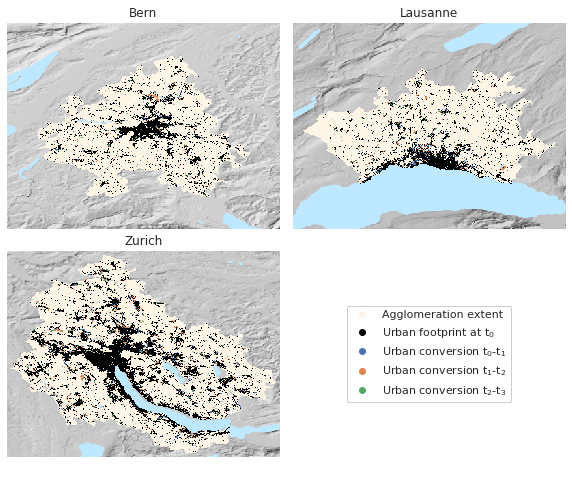

In [37]:
num_cols = 2
num_agglomerations = len(agglomeration_slugs)
num_rows = num_agglomerations // num_cols
if num_agglomerations % num_cols > 0:
    num_rows += 1

# plt.rcParams['axes.edgecolor'] = (0,0,0,0)
# plt.rcParams['axes.facecolor'] = (0,0,0,0)
agglmeration_extent_color = colors.to_rgba(colors.cnames['oldlace'], alpha=1)
base_cmap = colors.LinearSegmentedColormap.from_list('binaryalpha', [(0, 0, 0, 0), (0, 0, 0, 1), agglmeration_extent_color], 3)

delta_x = 0.01
delta_y = 0.01

# fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_rows * figwidth, num_cols * figheight), gridspec_kw={'wspace':0})
fig = plt.figure(figsize=(num_rows * 5, num_cols * figheight))
# fig.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0.05)
# for agglomeration_slug, ax in zip(agglomeration_slugs, axes.flat):
for i, agglomeration_slug in enumerate(agglomeration_slugs, start=1):
    ax = fig.add_subplot(num_rows, num_cols, i)
    ax.axis('off')
    ax.set_title(agglomeration_slug.capitalize())
    west, south, east, north = bounds_dict[agglomeration_slug]
    horizontal_margin = (min_width - (east - west)) / 2 + delta_x
    vertical_margin = (min_height - (north - south)) / 2 + delta_y
    _west = west - horizontal_margin
    _south = south - vertical_margin
    _east = east + horizontal_margin
    _north = north + vertical_margin
    x_start, y_start = rio_transform.rowcol(
        rio_transform.from_bounds(
            _west, _south, _east, _north, num_x_pixels, num_y_pixels),
        west, north)
    m = Basemap(epsg=epsg, llcrnrlon=_west, llcrnrlat=_south, urcrnrlon=_east, urcrnrlat=_north, ax=ax)
    # m.wmsimage('http://wms.geo.admin.ch/?', layers=['ch.swisstopo.images-landsat25'], ax=ax)
    img = m.wmsimage('https://image.discomap.eea.europa.eu/arcgis/services/Elevation/Hillshade/MapServer/WmsServer?', layers=['Image'])
    img.set_array(img.get_array().dot([.07, .72, .21]))
    img.set_cmap('gray')
    ax._sci(img)
    # ax.imshow(gray_img, cmap='gray', vmin=0, vmax=1)
    m.wmsimage('http://wms.geo.admin.ch/?', layers=['ch.bafu.gefahren-basiskarte.lakes'], transparent=True)
    

    sta = agglomeration_dict[agglomeration_slug]
    landscapes = sta.landscapes

    landscape_arr = landscapes[0].landscape_arr
    landscape_height, landscape_width = landscape_arr.shape
    plt_arr = np.zeros((landscape_height + 2 * x_start, landscape_width + 2 * y_start), dtype=np.uint8)
    plt_arr[x_start:x_start+landscape_height, y_start:y_start+landscape_width] = landscape_arr
    m.imshow(plt_arr, cmap=base_cmap, origin='upper', ax=ax)

    color_palette_iter = iter(sns.color_palette())
    for i in range(len(landscapes[:-1])):
        change_arr = (landscapes[i+1].landscape_arr == urban_class) & (landscapes[i].landscape_arr != urban_class)
        landscape_height, landscape_width = change_arr.shape
        plt_arr = np.zeros((landscape_height + 2 * x_start, landscape_width + 2 * y_start), dtype=bool)
        plt_arr[x_start:x_start+landscape_height, y_start:y_start+landscape_width] = change_arr
        r, g, b = next(color_palette_iter)
        m.imshow(plt_arr, cmap=colors.LinearSegmentedColormap.from_list(i, [(0, 0, 0, 0), (r, g, b, 1)], 2), origin='upper', ax=ax)

# generate a legend and place it in the last (empty) axis
ax = fig.add_subplot(num_rows, num_cols, 4)
# ax.set_facecolor()
ax.axis('off')
ax.plot(0, 0, 'o', c=agglmeration_extent_color, label='Agglomeration extent')
ax.plot(0, 0, 'o', c=(0, 0, 0), label=f'Urban footprint at t$_0$')
color_palette_iter = iter(sns.color_palette())
for i in range(len(landscapes[:-1])):
    r, g, b = next(color_palette_iter)
    ax.plot(0, 0, 'o', c=(r, g, b), label=f'Urban conversion t$_{i}$-t$_{i+1}$')
ax.legend(loc='center', facecolor='white', framealpha=1)

fig.savefig('../reports/figures/landscapes.pdf', **savefig_kws)

In [17]:
from PIL import Image

im = Image.open('../reports/figures/landscapes.pdf')

OSError: cannot identify image file '../reports/figures/landscapes.pdf'

In [ ]:
def foo(bounds, min_width, min_height, num_x_pixels, num_y_pixels):
    west, south, east, north = bounds
    horizontal_margin = (min_width - (east - west)) / 2
    vertical_margin = (min_height - (north - south)) / 2
    _west = west - horizontal_margin
    _south = south - vertical_margin
    _east = east + horizontal_margin
    _north = north + vertical_margin
    return rio_transform.rowcol(
        rio_transform.from_bounds(
            _west, _south, _east, _north, num_x_pixels, num_y_pixels),
        west, north)

In [414]:
i = 0

In [415]:
f'Change t$_{i}$-t$_{i+1}$'

'Change t$_0$-t$_1$'

In [385]:
from matplotlib.transforms import Bbox

In [386]:
kws = savefig_kws.copy()
kws.update({'bbox_inches': Bbox([[fig.bbox_inches.xmin, fig.bbox_inches.ymin], [fig.bbox_inches.xmax - .4, fig.bbox_inches.xmax]])})
fig.savefig('../reports/figures/landscapes.pdf', **kws)

In [374]:
print(fig.bbox_inches)
fig.subplots_adjust(hspace=.2, wspace=-.2)
print(fig.bbox_inches)
# fig.savefig('../reports/figures/landscapes.pdf', **savefig_kws)

Bbox(x0=0.0, y0=0.0, x1=12.0, y1=8.0)
Bbox(x0=0.0, y0=0.0, x1=12.0, y1=8.0)


In [106]:
import rasterio as rio
from affine import Affine
from rasterio import transform as rio_transform
from rasterio import warp as rio_warp

In [88]:
transform_dict['zurich']

Affine(100.0, 0.0, 664550.0,
       0.0, -100.0, 276550.0)

In [107]:
bounds

(8.29048577890058, 47.155717413779044, 8.923467462690141, 47.62966315525461)

Affine(100.0, 0.0, 8.29048577890058,
       0.0, -100.0, 47.62966315525461)

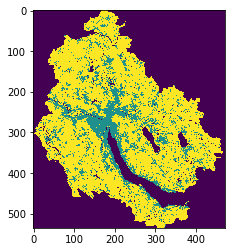

In [122]:
agglomeration_slug = 'zurich'
src_arr = agglomeration_dict[agglomeration_slug].landscapes[0].landscape_arr
dst_arr = np.zeros_like(src_arr)
rio_warp.reproject(
    src_arr,
    dst_arr,
    src_transform=transform_dict[agglomeration_slug],
    src_crs=ldf.crs,
    dst_transform=rio_transform.from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], dst_arr.shape[1], dst_arr.shape[0]),
    dst_crs={'init': 'epsg:4326'})

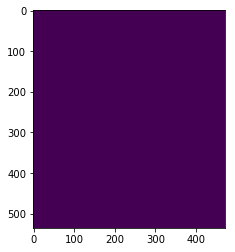

In [75]:
transform_dict['zurich'] * agglomeration_dict['zurich'].landscapes[0].landscape_arr

ValueError: operands could not be broadcast together with shapes (9,) (535,471) 

In [ ]:
agglomeration_dict['zurich'].landscapes[0].landscape_arr

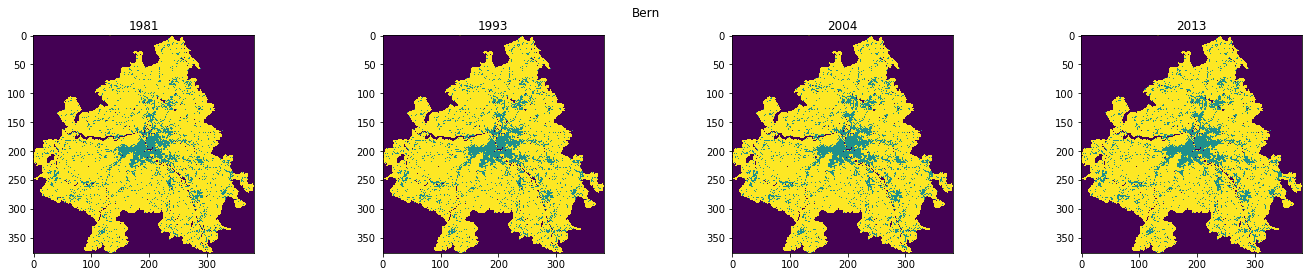

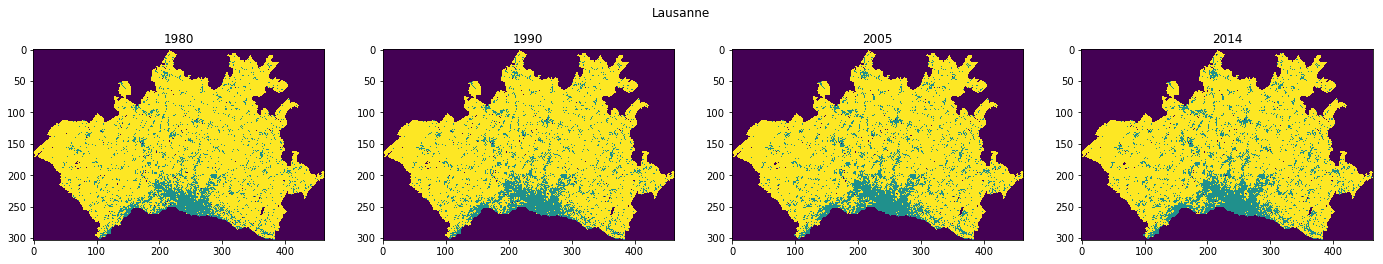

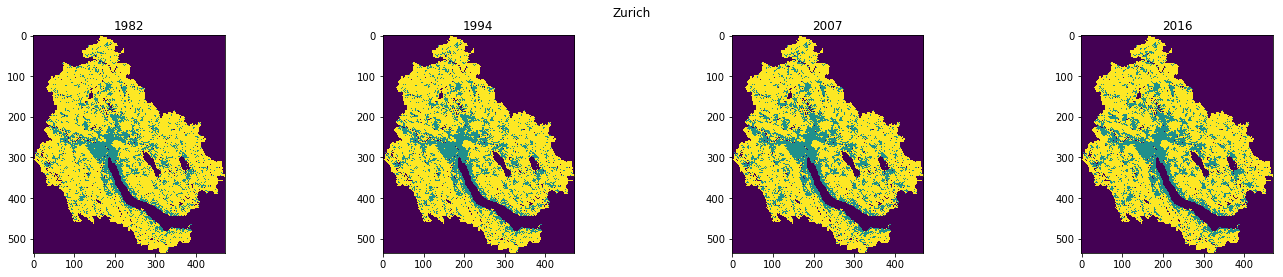

In [5]:
for agglomeration_slug in agglomeration_slugs:
    fig, axes = agglomeration_dict[agglomeration_slug].plot_landscapes()
    fig.suptitle(agglomeration_slug.capitalize())